In [2]:
%matplotlib inline
import numpy as np
import math
import scipy as sc
import time, datetime
import pandas as pd
import random
import matplotlib.pyplot as plt
from numpy import *
from sklearn import metrics
import seaborn as sns
from collections import Counter
from scipy import stats, integrate
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn import cross_validation
from mpl_toolkits.mplot3d import Axes3D

/Users/MoniaBayakissa/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
orders = '../Weather_Impact/example_orders.csv'
weather = '../Weather_Impact/example_weather.csv'

In [9]:
orders_df = pd.read_csv(orders, sep=',',header=0, encoding='latin-1', error_bad_lines=False,index_col = 0)
weather_df = pd.read_csv(weather, sep=';',header=0, encoding='latin-1', date_parser=lambda t: datetime.date.strptime(t, '%Y-%m-%d').date(), error_bad_lines=False)

In [10]:
# Converting dates to the same format

weather_df['Time'] = pd.to_datetime(weather_df['Time'])
weather_df['Time'] = weather_df['Time'].apply(lambda x:x.date().strftime('%d/%m/%Y'))

orders_df['day'] = pd.to_datetime(orders_df['day'])
orders_df['day'] = orders_df['day'].apply(lambda x:x.date().strftime('%d/%m/%Y'))

In [12]:
# Rearranging dataset and summing precipitation per day

#weather_df = weather_df.drop(['Unnamed: 2', 'Unnamed: 3'], 1)
weather_df = weather_df[weather_df['Precipitation'] != 'n/a']
weather_df['Precipitation'] = [ float(_) for _ in weather_df['Precipitation']]
weather_df = weather_df.groupby(by=['Time'], as_index=False)['Precipitation'].sum()

/Users/MoniaBayakissa/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/Users/MoniaBayakissa/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


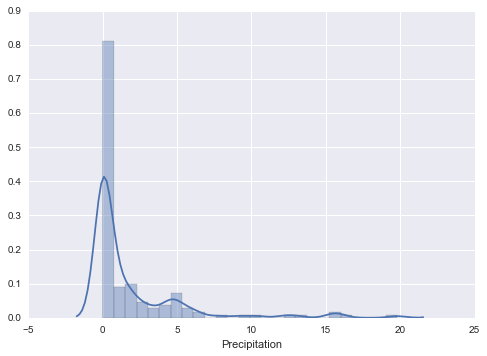

In [14]:
sns.distplot(weather_df.Precipitation)

In [44]:
# Joining both datasets by date

order_weather = orders_df.merge(weather_df, left_on=['day'], right_on=['Time'], how='inner')
#order_weather = order_weather.drop('Time', 1)

In [45]:
threshold = weather_df.Precipitation.mean()
threshold

1.870833333333334

In [46]:
order_weather.head()

,cancelled_reason,user_id,day,Time,Precipitation
0,0,16496,13/12/2013,13/12/2013,0.2
1,0,1014,13/12/2013,13/12/2013,0.2
2,0,16522,13/12/2013,13/12/2013,0.2
3,0,26328,13/12/2013,13/12/2013,0.2
4,0,7138,13/12/2013,13/12/2013,0.2


Considering Jinn is a 24h service platform AND we only have here the date of order not the time, we will consider the sum of precipitation for the whole day to categorize it as a 'rainy day' or not.

Researches have provided the information that a rainy day (London) is a day where 1mm of rain or more falls (Met Office Climate).
The mean of precipitation in our dataset is about 1.87 mm, so this is the threshold we are going to use to define a rainy day here.

We can then divide the data between days with ~< 1.87 mm of rain and days with ~>= 1.87 mm of rain.

In [47]:
order_weather['Rainy_Day'] = pd.Series(np.random.randn(len(order_weather)), index=order_weather.index)

order_weather.Rainy_Day = [1 if _ >= threshold else 0 for _ in order_weather.Precipitation]

The features 'day' and 'cancelled_reason' are not useful here. Cancelled or not, an order was placed, so these rows will still be considered in our classification.

In [48]:
order_weather = order_weather.drop(['day', 'cancelled_reason'], 1)

In [49]:
ordernb = pd.DataFrame({'Count_Order': pd.Series(dict(Counter(order_weather.user_id)))})
ordernb.head()

,Count_Order
0,4
1,13
2,16
3,49
4,61


In [50]:
rain = order_weather.groupby(by=['user_id'], as_index=False)['Rainy_Day'].sum()

In [51]:
precip_order = ordernb.merge(rain, left_index=True, right_on=['user_id'], how='inner')
precip_order = precip_order.drop('user_id', 1)
precip_order.head()

,Count_Order,Rainy_Day
0,4,3
1,13,2
2,16,7
3,49,9
4,61,16


In [52]:
precip_order = precip_order[precip_order.Count_Order != 1]

In [53]:
precip_order['Average_Precip']=[x/y for x,y in zip(precip_order.Rainy_Day,precip_order.Count_Order)]

In [54]:
precip_order.head()

,Count_Order,Rainy_Day,Average_Precip
0,4,3,0.750000
1,13,2,0.153846
2,16,7,0.437500
3,49,9,0.183673
4,61,16,0.262295


In [120]:
len(precip_order[precip_order.Average_Precip > 0.5]), len(precip_order[precip_order.Average_Precip <= 0.5])

(1667, 11772)

Based on this results, we could conclude people seem to be more likely to order on "NOT rainy days".

In [57]:
cluster_test = orders_df.merge(order_weather, left_on = ['day', 'user_id'], right_on = ['Time', 'user_id'], how = 'inner')
cluster_test.head()

,cancelled_reason,user_id,day,Time,Precipitation,Rainy_Day
0,0,16496,13/12/2013,13/12/2013,0.2,0
1,0,1014,13/12/2013,13/12/2013,0.2,0
2,0,16522,13/12/2013,13/12/2013,0.2,0
3,0,26328,13/12/2013,13/12/2013,0.2,0
4,0,7138,13/12/2013,13/12/2013,0.2,0


In [66]:
cluster_test = cluster_test.drop(['day', 'Time'], 1)

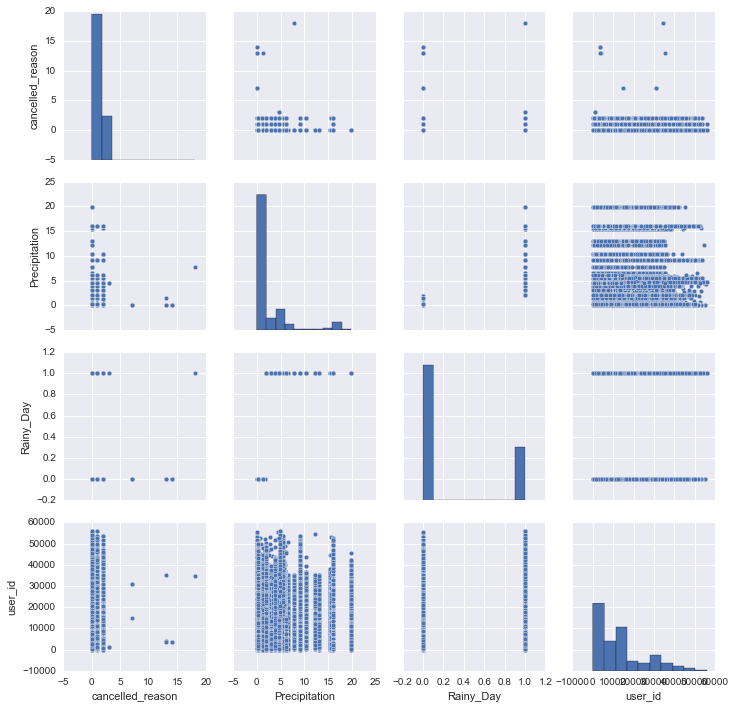

In [67]:
plot = sns.pairplot(cluster_test)

/Users/MoniaBayakissa/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


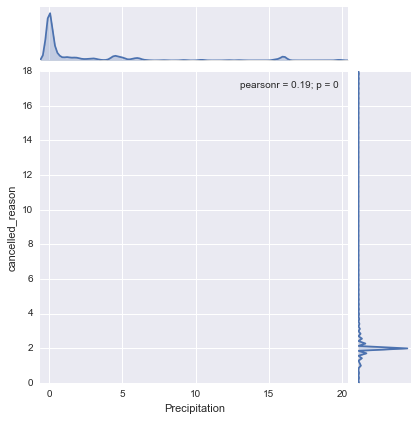

In [75]:
sns.jointplot(cluster_test.Precipitation,cluster_test.cancelled_reason,kind='kde')

When pairplotting, we notice we do not have any particular cluster forming, even when using a density factor.
We will still try to run a Kmean algorithm on the data with separately the feature 'Precipitation' and 'Rainy_Day' to see if we can see any cluster forming automatically on the dataset.

In [90]:
cluster_test['Rainy_Day'] = pd.Series(np.random.randn(len(cluster_test)), index=cluster_test.index)

cluster_test.Rainy_Day = [1 if _ >= threshold else 0 for _ in cluster_test.Precipitation]

In [91]:
cols = list(cluster_test)
cols.insert((shape(cluster_test)[1])-1, cols.pop(cols.index('user_id')))
cluster_test = cluster_test.ix[:, cols]
cluster_test = cluster_test.drop('Precipitation', 1)

In [92]:
array = cluster_test.values
X = array[:,0:(shape(cluster_test)[1]-1)]
X

array([[0, 0],
       [0, 0],
       [0, 0],
       ..., 
       [0, 1],
       [0, 1],
       [0, 1]])

In [93]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

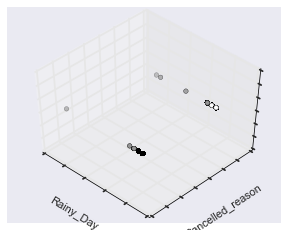

In [94]:
# 'Rainy Day'

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
kmeans.fit(X)
labels = kmeans.labels_

ax.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float))

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Rainy_Day')
ax.set_ylabel('Cancelled_reason')
ax.set_zlabel('user_id')

In [108]:
cluster_test = orders_df.merge(order_weather, left_on = ['day', 'user_id'], right_on = ['Time', 'user_id'], how = 'inner')
cluster_test = cluster_test = cluster_test.drop(['day', 'Time'], 1)
cluster_test.head()

,cancelled_reason,user_id,Precipitation,Rainy_Day
0,0,16496,0.2,0
1,0,1014,0.2,0
2,0,16522,0.2,0
3,0,26328,0.2,0
4,0,7138,0.2,0


In [109]:
cluster_test['Rainy_Day'] = pd.Series(np.random.randn(len(cluster_test)), index=cluster_test.index)

cluster_test.Rainy_Day = [1 if _ >= threshold else 0 for _ in cluster_test.Precipitation]

In [110]:
cols = list(cluster_test)
cols.insert((shape(cluster_test)[1])-1, cols.pop(cols.index('user_id')))
cluster_test = cluster_test.ix[:, cols]
cluster_test = cluster_test.drop('Rainy_Day', 1)

In [111]:
array = cluster_test.values
X = array[:,0:(shape(cluster_test)[1]-1)]
X

array([[ 0. ,  0.2],
       [ 0. ,  0.2],
       [ 0. ,  0.2],
       ..., 
       [ 0. ,  3. ],
       [ 0. ,  3. ],
       [ 0. ,  3. ]])

In [112]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

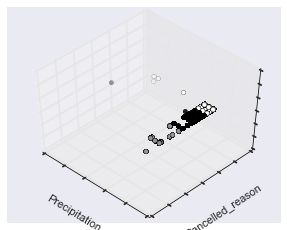

In [113]:
# 'Precipitation'

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
kmeans.fit(X)
labels = kmeans.labels_

ax.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float))

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Precipitation')
ax.set_ylabel('Cancelled_reason')
ax.set_zlabel('user_id')

The only noticeable thing in this plot above is that there is way more order cancellation on rainy days, but it does not concern the orders' placement themselves.

/Users/MoniaBayakissa/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


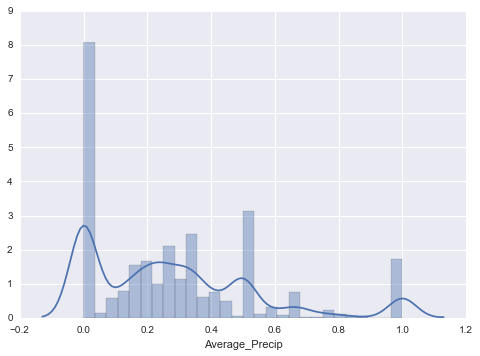

In [122]:
sns.distplot(precip_order.Average_Precip)

In [127]:
print(len(precip_order[precip_order.Average_Precip > 0.8]), ' out of ' ,len(precip_order) , ' customers have ordered on almost or only \'rainy days\'.')

870  out of  13439  customers have ordered on almost or only 'rainy days'.


#### Conclusion

We've seen during this whole analysis and considering the data available to do it that it's difficult to put a "model" in place categorizing customers into being more likely to order on rainy days.

However this last plot shows us peaks of orders at certain amount of precipitation.
The very last metric obtained highlights customers who happened to have ordered almost or only on rainy days. 

This kind of metric can be used in a way to maybe target customers on forcasted rainy days so they can receive ideas of order or offers on orders they may place on that day.